In [1]:
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import numpy as np

from langdetect import detect

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import CoherenceModel

from pprint import pprint

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'javascript'])

from bs4 import BeautifulSoup

import pyLDAvis
import pyLDAvis.gensim

import ast
from collections import Counter
from operator import add
from wordcloud import WordCloud

# import stanza
# stanza.download('en')
# nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma', use_gpu=False)

In [2]:
df_test = pd.read_csv('../data/testset.csv')
df_test.drop(columns='Unnamed: 0', inplace=True)
# convert the string representation of a list into a list
df_test['body_text'] = df_test['body_text'].apply(ast.literal_eval)
df_test['title'] = df_test['title'].apply(ast.literal_eval)
df_test['body_token'] = df_test['body_token'].apply(ast.literal_eval)
df_test['title_token'] = df_test['title_token'].apply(ast.literal_eval)

In [3]:
# show the english domains
df_test_eng = df_test[df_test['language'] == 'en']
df_test_eng

,domain_name,domain,url,title,body_text,body_token,title_token,language
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...","[clone, card]",en
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]","[machin, error]",en
2,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...","[credit, card, wester, union, moneygram, accou...",en
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...","[darknet, site, onlin]",en
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...","[lt, lt, lt, gt, gt, chao, comput, club, dresden]",en
...,...,...,...,...,...,...,...,...
1304,| TheYOSH.nl,['ctzzqqimlfamyhrc'],['ctzzqqimlfamyhrc.onion'],[| TheYOSH.nl],"[| TheYOSH.nl, Skip to main content, User acco...","[theyosh, nl, skip, content, user, account, me...","[theyosh, nl]",en
1321,✉ Guerrilla Mail on Tor,['grrmailb3fxpjbwm'],['grrmailb3fxpjbwm.onion'],[✉ Guerrilla Mail on Tor],"[✉ Guerrilla Mail on Tor, TorGuerrillaMail - D...","[guerrilla, mail, tor, dispos, mail, address, ...","[guerrilla, mail, tor]",en
1322,✔ Legit Carding Services ♛ Money Transfer Worl...,['greenegbqkyk3ois'],['greenegbqkyk3ois.onion'],[✔ Legit Carding Services ♛ Money Transfer Wor...,[✔ Legit Carding Services ♛ Money Transfer Wor...,"[card, servic, money, transfer, worldwid, webs...","[card, servic, money, transfer, worldwid, webs...",en
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]",en


In [4]:
# show the non-english domains
df_test_non_eng = df_test[df_test['language'] != 'en']
df_test_non_eng

,domain_name,domain,url,title,body_text,body_token,title_token,language
6,*** JES 2020 *** Кшись и Компания. Частное рад...,['73ovw2epsc4kga45lhz4sm3ulfzemdzlhxlj6p2b7i4p...,['73ovw2epsc4kga45lhz4sm3ulfzemdzlhxlj6p2b7i4p...,[*** JES 2020 *** Кшись и Компания. Частное ра...,[*** JES 2020 *** Кшись и Компания. Частное ра...,"[je, кшись, компания, частное, радио, телевиде...","[je, кшись, компания, частное, радио, телевиде...",ru
22,24BOT,['24boths2mh6sxaz5'],['24boths2mh6sxaz5.onion'],[24BOT],"[24BOT, 24boths2mh6sxaz5.onion - моментальный ...","[bot, mh, sxaz, onion, моментальный, магазин, ...",[bot],ru
23,2channel,['2chagyntyms53ruy'],['2chagyntyms53ruy.onion'],[2channel],"[2channel, 2channel.moe, Добро пожаловать., О ...","[channel, channel, moe, добро, пожаловать, общ...",[channel],ru
25,404 - Not found,['2vxi4nmjcn6mdb2x'],['2vxi4nmjcn6mdb2x.onion'],[404 - Not found],"[404 - Not found, Error 404: Not Found]","[found, error]",[found],da
53,Accueil,['djypjjvw532evfw3'],['djypjjvw532evfw3.onion'],[Accueil],"[Accueil, Accueil, Produits, Contact/Commande,...","[accueil, accueil, produit, contact, command, ...",[accueil],fr
...,...,...,...,...,...,...,...,...
1328,暗网中文担保交易市场,['txxh3pmeihpcw4pe'],['txxh3pmeihpcw4pe.onion'],[暗网中文担保交易市场],"[暗网中文担保交易市场, 本市场并无分号，独此一家，其他均为假冒。价格显示为美元，支付结算时...","[暗网中文担保交易市场, 独此一家, 其他均为假冒, 价格显示为美元, 支付结算时将转换为比...",[暗网中文担保交易市场],zh-cn
1329,暗网中文担保交易市场 - 一个小高端中文安全买卖平台暗网中文担保交易市场,"['m6onsfnvo4iolyix', 'moi3v3c77y5ckdsh']","['m6onsfnvo4iolyix.onion', 'moi3v3c77y5ckdsh.o...","[暗网中文担保交易市场 - 一个小高端中文安全买卖平台暗网中文担保交易市场, 暗网中文担保交...","[暗网中文担保交易市场 - 一个小高端中文安全买卖平台暗网中文担保交易市场, 本市场独此一家...","[暗网中文担保交易市场, 其他均为假冒, 价格显示为美元, 支付结算时将转换为比特币, 莱特...","[暗网中文担保交易市场, 暗网中文担保交易市场, 关于春节期间安排的通知, 买家规则, 担保...",zh-cn
1330,淡路島,['a5h4uuqoovwvcbiecjkjlu7ew7z4lszfv67dodqol2iv...,['a5h4uuqoovwvcbiecjkjlu7ew7z4lszfv67dodqol2iv...,[淡路島],"[淡路島, 淡路島 - コシニテ人びとへの手紙 -, 玉ねぎを育もう, Update, 20...","[淡路島, 淡路島, コシニテ人びとへの手紙, 玉ねぎを育もう, updat, scale,...",[淡路島],ja
1332,茶马古道,['7zj4oshsyhokgus6fyk7pmdiubu4mkjpjjprjkvopnhn...,['7zj4oshsyhokgus6fyk7pmdiubu4mkjpjjprjkvopnhn...,[茶马古道],"[茶马古道, 茶马护盾已开启欢迎来到茶马古道，页面跳转中...]","[茶马古道, 茶马护盾已开启欢迎来到茶马古道, 页面跳转中]",[茶马古道],ko


In [5]:
# build Bag of Words corpus
docs = df_test['body_token']
dictionary = gensim.corpora.Dictionary(docs)
# dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [6]:
# build TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [7]:
# train a list of LDA models with coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [8]:
# hyper parameters defining the range of LDA model's number of topics
topics_limit = 10
topics_start = 2
topics_step = 2

In [9]:
# run the training session on Bag of Words corpus
bow_model_list, bow_coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, 
                                                        texts=docs, limit=topics_limit, start=topics_start, step=topics_step)

In [10]:
# run the training session on TF-IDF corpus
tfidf_model_list, tfidf_coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, 
                                                        texts=docs, limit=topics_limit, start=topics_start, step=topics_step)

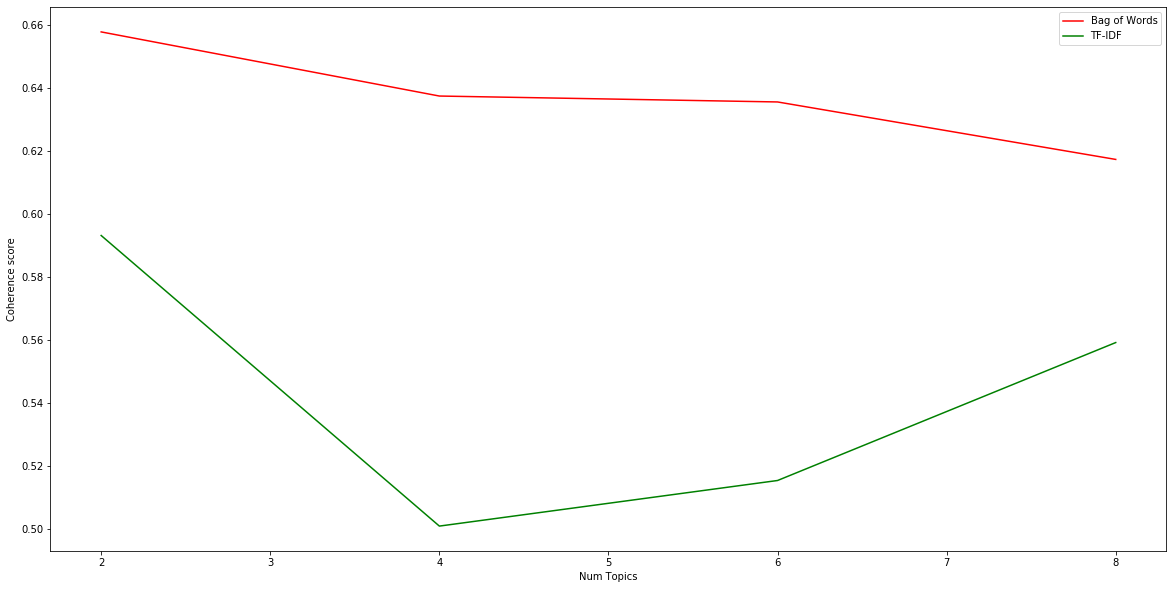

In [11]:
# show coherence values of each model
plt.figure(figsize=(20,10))
x = range(topics_start, topics_limit, topics_step)
plt.plot(x, bow_coherence_values, color = "red", label = "Bag of Words")
plt.plot(x, tfidf_coherence_values, color = "green", label = "TF-IDF")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

In [12]:
# print the coherence scores for models trained on Bag of Words
for m, cv in zip(x, bow_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6578
Num Topics = 4  has Coherence Value of 0.6375
Num Topics = 6  has Coherence Value of 0.6356
Num Topics = 8  has Coherence Value of 0.6173


In [13]:
# print the coherence scores for models trained on TF-IDF
for m, cv in zip(x, tfidf_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5932
Num Topics = 4  has Coherence Value of 0.5009
Num Topics = 6  has Coherence Value of 0.5153
Num Topics = 8  has Coherence Value of 0.5592


In [14]:
# select the optimal model (i.e. the model with the highest coherence value) and print the topics
model_list = bow_model_list + tfidf_model_list
coherence_values = bow_coherence_values + tfidf_coherence_values
optimal_model_index = np.argmax(coherence_values)
optimal_model = model_list[optimal_model_index]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.037*"card" + 0.018*"transfer" + 0.013*"money" + 0.012*"btc" + '
  '0.012*"order" + 0.010*"price" + 0.009*"payment" + 0.009*"account" + '
  '0.008*"pay" + 0.008*"gift"'),
 (1,
  '0.024*"card" + 0.016*"transfer" + 0.014*"btc" + 0.009*"account" + '
  '0.009*"money" + 0.009*"order" + 0.008*"bitcoin" + 0.007*"union" + '
  '0.006*"payment" + 0.006*"store"')]


In [15]:
# check whether the optimal model is trained on Bag of Words
if optimal_model_index > 13:
    is_bow = False
else:
    is_bow = True

In [16]:
# compute perplexity: a measure of how good the model is. lower the better.
print('Perplexity: ', optimal_model.log_perplexity(bow_corpus))

# print coherence value
print('Coherence Value: ', coherence_values[optimal_model_index])

Perplexity:  -7.649871523795152
Coherence Value:  0.657819753697221


In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
if is_bow:
    vis = pyLDAvis.gensim.prepare(optimal_model, bow_corpus, dictionary)
else:
    vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.022292  0.0       1        1  60.856735
1     -0.022292  0.0       2        1  39.143261, topic_info=        Term          Freq         Total Category  logprob  loglift
237    store  10675.000000  10675.000000  Default  30.0000  30.0000
29   bitcoin  18798.000000  18798.000000  Default  29.0000  29.0000
33       btc  37130.000000  37130.000000  Default  28.0000  28.0000
255      usd  11841.000000  11841.000000  Default  27.0000  27.0000
167      pay  16817.000000  16817.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
53       com   4224.420410  11291.634766   Topic2  -5.6003  -0.0452
69       day   4340.407227  12598.093750   Topic2  -5.5732  -0.1276
22    balanc   4273.598633  12871.516602   Topic2  -5.5888  -0.1646
179    price   4653.791016  21756.468750   Topic2  -5.5035  -0.6043
38      cash   4271.529297  14355.210938   Topic2  -5.5892  -0.2742

[207 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2          1  0.605694  account
2          2  0.394338  account
10663      1  0.061079   accout
10663      2  0.939940   accout
3          1  0.565733  address
...      ...       ...      ...
3487       2  0.664544       на
50272      1  0.300025  область
50272      2  0.699671  область
3531       1  0.264700       по
3531       2  0.735003       по

[313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [18]:
# find the dominant (aka main) topic for each domain
def format_topics_sentences(ldamodel, corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
# show the dominant topics and texts
if is_bow:
    df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=docs)
else:
    df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_tfidf, texts=docs)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.drop(columns='Document_No', inplace=True)
df_dominant_topic.head()

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9559,"card, transfer, money, btc, order, price, paym...","[clone, card, home, price, ship, question, con..."
1,1.0,0.7081,"card, transfer, btc, account, money, order, bi...","[machin, error, log, session, ha, expir, pleas]"
2,0.0,0.9928,"card, transfer, money, btc, order, price, paym...","[credit, card, wester, union, moneygram, accou..."
3,1.0,0.9964,"card, transfer, btc, account, money, order, bi...","[ark, darknet, site, onlin, darknet, site, onl..."
4,1.0,0.9941,"card, transfer, btc, account, money, order, bi...","[chao, comput, club, dresden, chao, comput, cl..."


In [20]:
# show the bag of words in the first domain
for i in range(len(bow_corpus[0])):
    print("Word {} (\"{}\") appears {} time.".format(bow_corpus[0][i][0], 
                                                     dictionary[bow_corpus[0][i][0]], bow_corpus[0][i][1]))

Word 0 ("absolut") appears 1 time.
Word 1 ("accept") appears 1 time.
Word 2 ("account") appears 12 time.
Word 3 ("address") appears 7 time.
Word 4 ("africa") appears 3 time.
Word 5 ("agre") appears 1 time.
Word 6 ("alreadi") appears 1 time.
Word 7 ("amount") appears 4 time.
Word 8 ("ani") appears 3 time.
Word 9 ("anonym") appears 1 time.
Word 10 ("anyon") appears 1 time.
Word 11 ("anywher") appears 1 time.
Word 12 ("area") appears 1 time.
Word 13 ("aris") appears 1 time.
Word 14 ("asap") appears 1 time.
Word 15 ("asia") appears 2 time.
Word 16 ("ask") appears 4 time.
Word 17 ("atm") appears 7 time.
Word 18 ("attent") appears 2 time.
Word 19 ("australia") appears 1 time.
Word 20 ("author") appears 1 time.
Word 21 ("avail") appears 2 time.
Word 22 ("balanc") appears 4 time.
Word 23 ("base") appears 1 time.
Word 24 ("basi") appears 1 time.
Word 25 ("becam") appears 1 time.
Word 26 ("becaus") appears 1 time.
Word 27 ("befor") appears 1 time.
Word 28 ("bicbhpscr") appears 1 time.
Word 29 ("

In [21]:
# show the TF-IDF in the first domain
for i in range(len(corpus_tfidf[0])):
    print("Word {} (\"{}\") appears {} time.".format(corpus_tfidf[0][i][0], 
                                                     dictionary[corpus_tfidf[0][i][0]], corpus_tfidf[0][i][1]))

Word 0 ("absolut") appears 0.022382776006962368 time.
Word 1 ("accept") appears 0.02230413481460508 time.
Word 2 ("account") appears 0.10386913647194002 time.
Word 3 ("address") appears 0.06083794187993036 time.
Word 4 ("africa") appears 0.0671483280208871 time.
Word 5 ("agre") appears 0.024116543583291246 time.
Word 6 ("alreadi") appears 0.021129839495000108 time.
Word 7 ("amount") appears 0.05545017534023801 time.
Word 8 ("ani") appears 0.03113771233585519 time.
Word 9 ("anonym") appears 0.012265180406052555 time.
Word 10 ("anyon") appears 0.02040181715304117 time.
Word 11 ("anywher") appears 0.025339910485969563 time.
Word 12 ("area") appears 0.01943654175845778 time.
Word 13 ("aris") appears 0.027275848892261145 time.
Word 14 ("asap") appears 0.027010275437930286 time.
Word 15 ("asia") appears 0.0436919144243768 time.
Word 16 ("ask") appears 0.06848549238668451 time.
Word 17 ("atm") appears 0.10516658367777418 time.
Word 18 ("attent") appears 0.045738698496097796 time.
Word 19 ("au

Word 263 ("wallet") appears 0.04149430398606609 time.
Word 264 ("want") appears 0.021129839495000108 time.
Word 265 ("way") appears 0.012972364292541012 time.
Word 266 ("websit") appears 0.0326486144351162 time.
Word 267 ("week") appears 0.032464034367290825 time.
Word 268 ("westernunion") appears 0.023742547056962614 time.
Word 269 ("whi") appears 0.029353448493964273 time.
Word 270 ("wonder") appears 0.024606587800989364 time.
Word 271 ("work") appears 0.03732776410991359 time.
Word 272 ("world") appears 0.053192732641622664 time.
Word 273 ("worldwid") appears 0.029906646292924433 time.
Word 274 ("wu") appears 0.04774409741995101 time.
Word 275 ("ye") appears 0.05344205517367713 time.
Word 276 ("year") appears 0.027725087670119004 time.
Word 277 ("yourselv") appears 0.024116543583291246 time.
Word 278 ("yuo") appears 0.02873314278375656 time.
Word 279 ("zero") appears 0.026256839369115978 time.


In [22]:
# show the topics of the first domain
if is_bow:
    for index, score in sorted(optimal_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
        print("\nScore: {}\t \nTopic: {}".format(score, optimal_model.print_topic(index, 5)))
else:
    for index, score in sorted(optimal_model[corpus_tfidf[0]], key=lambda tup: -1*tup[1]):
        print("\nScore: {}\t \nTopic: {}".format(score, optimal_model.print_topic(index, 5)))


Score: 0.9536446928977966	 
Topic: 0.037*"card" + 0.018*"transfer" + 0.013*"money" + 0.012*"btc" + 0.012*"order"

Score: 0.04635535553097725	 
Topic: 0.024*"card" + 0.016*"transfer" + 0.014*"btc" + 0.009*"account" + 0.009*"money"
